In [1]:
#Imports:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Options:
sns.set_style('darkgrid')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
%matplotlib inline

In [2]:
# 1. Questão de negócio
# 1)	Quais imóveis a House Rocket deve comprar e por qual preço?
# 2)	Uma vez comprado, qual melhor momento para vender o imóvel e por qual preço?
# Entendimento de Negócio
# 1)	Produtos finais (o que realmente vou entregar?)
# 3 relatórios:
# 1º relatório com sugestão de compras dos imóveis por um valor recomendado.
# 2º relatório em PDF contendo estrutura semelhante ao do projeto https://gitlab.com/datascience-community/pa001_cardio_catch_diseases
# 
# 2)	Quais são as ferramentas?
# Editor de PDF, editor de texto, jupyter notebook, streamlit.
# 
# 3)	Processo (quais os passos necessários para alcançar os objetivos?)
# 1.3.1 Coleta dos dados da Kaggle;
# 1.3.2 Limpeza dos dados e determinação de valor para exclusão de outliers (clean_data);
# 1.3.3 Agrupamento dos dados por região e por estação do ano (inverno ou demais estações) (set_data);
# 1.3.4 Determinação da mediana de preço para imóveis no inverno e em demais estações (set_data);
# 1.3.5 Criação de variáveis para melhor análise exploratória de dados (is_renovated, is_winter) (set_data);
# 1.3.6 A compra dos imóveis será aplicada em duas possibilidades:
# a) Os imóveis que foram anunciados em outras estações com exceção do inverno, terão seus valores de compra comparados com a mediana de preço dos demais imóveis com estações similares e códigos postais idênticos.
# b) Os imóveis que foram anunciados no inverno serão distribuidos em um novo grupo e o preço desses imóveis será comparado a mediana do preço dos imóveis no mesmo código postal que também estão sendo anunciados durante o inverno.
# 1.3.7 Determinação dos imóveis que valem a pena serem comprados e preço e geração de relatório em PDF (buying_list);
# 1.3.8 Análise exploratória de dados;
# 1.3.9 Conclusão;

# 2. Premissas
# 2.1 Da aquisição e venda dos imóveis
# a) Somente casas com valores de compra abaixo da mediana por código postal serão compradas;
# b) As casas terão preço de venda de 130% sobre o preço de compra;
# 2.2 Da reestruturação de dados
# a) Valores outliers serão excluídos;
# b) Valores duplicados na coluna "ID" serão excluídos;
# c) A coluna "price" corresponde ao preço de compra dos imóveis;
# d) A coluna is_winter foi criada com o intuito de validar se durante o período de compra do imóvel a estação vigente era o inverno, permitindo legitimação de um dos insights de negócio. 
# e) A coluna median_price e winter_median_price foram criada com o intuito de comparar o preço de compra da casa com o valor da mediana de compra do grupo de casas naquele código-postal (zipcode), permitindo movimentações de compras mais proveitosas financeiramente.
# f) A coluna is_renovated evidencia as casas que foram reformadas, possibilitando melhor análise estrutural de dados.
# g) A coluna worth_buying descreve quais casas valem a pena ser compradas de acordo com as métricas estabelecidas no projeto.
    
# 3. Planejamento da solução
# 3.1 Importação dos dados do Kaggle (inserir link);
# 3.2 Limpeza e estruturação dos dados;
# 3.3 Análise exploratória dos dados;
# 3.4 Validação de insights.
# 3.5 Hospedagem dos arquivos do site no Heroku.
 
# 4. Os 3 principais insights de negócio
# 4.1 Casas vendidas no inverno são pelo menos 20% mais baratas, visto que não há muita mobilidade e as pessoas vendem na internet;
# a) Aplicação: Torna a compra de casas em massa no inverno mais interessante diante da possibilidade de um desconto maior no valor dessas casas;
# 4.2 Casas reformadas são ao menos 30% mais caras que casas que não passaram por reformas;
# a) Aplicação: Informa se a compra de casas não reformadas é viável para revenda caso seja possível aplicar uma pequena reforma na casa e ganhar no valor de venda final;
# 4.3 Casas com vista em frente à rios ou ao mar são pelo menos 20% mais caras;
# a) Aplicação: Permite estudar a melhor oportunidade para comprar casas com vista de frente para rios ou mares e revender.

# 5. Resultados financeiros para o negócio
 
# 6. Conclusão
 
# 7. Proximos passos

In [3]:
def load_data():
    df = pd.read_csv('kc_house_data.csv')
    return df

In [4]:
def clean_data(df):
    df.drop_duplicates(subset=['id'], keep='first', inplace=True)
    df.drop(['grade', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)
    q1 = df['price'].quantile(0.25)
    q3 = df['price'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr
    ls = df.index[(df['price'] < lower_bound) | (df['price'] > upper_bound) ]
    df.drop(ls, inplace=True)
    df = df.reset_index()
    return df

In [5]:
def set_data(df):
    df['date'] = pd.to_datetime(df['date'])
    df_temp = df.groupby('zipcode')['price'].median().reset_index()
    df_temp.columns=['zipcode','median_price']
    df = pd.merge(df,df_temp,on='zipcode',how='inner')
    for i in range(len(df)):
        if (df.loc[i, 'date'].month == 12) | (df.loc[i, 'date'].month <= 3):
            df.loc[i, 'is_winter'] = 1
        else:
            df.loc[i, 'is_winter'] = 0
    df_temp = df[['zipcode', 'is_winter','price']].groupby(['zipcode', 'is_winter']).median().reset_index()
    df_temp = df_temp[df_temp['is_winter'] == 1].drop('is_winter', axis=1)
    df_temp.columns=['zipcode','winter_median_price']
    df = pd.merge(df, df_temp, on='zipcode', how='inner')
    df['profit_value'] = np.nan
    df['selling_price'] = np.nan
    for i in range(len(df)):
        if df.loc[i, 'is_winter'] == 0:
                if (df.loc[i, 'price'] < df.loc[i, 'median_price']) & (df.loc[i, 'condition'] >= 3):
                    df.loc[i, 'selling_price'] = df.loc[i, 'price']*1.2
                    df.loc[i, 'profit_value'] = df.loc[i, 'selling_price']-df.loc[i, 'price']
                    df.loc[i, 'worth_buying'] = 1
                else: 
                    df.loc[i, 'worth_buying'] = 0
        else:
                if (df.loc[i, 'price'] < df.loc[i, 'winter_median_price']) & (df.loc[i, 'condition'] >= 3):
                    df.loc[i, 'selling_price'] = df.loc[i, 'price']*1.2
                    df.loc[i, 'profit_value'] = df.loc[i, 'selling_price']-df.loc[i, 'price']
                    df.loc[i, 'worth_buying'] = 1
                else: 
                    df.loc[i, 'worth_buying'] = 0
    for i in range(len(df)):
        if df.loc[i, 'yr_renovated'] > 0:
            df.loc[i, 'is_renovated'] = 1
        else:
            df.loc[i, 'is_renovated'] = 0
    return df

In [6]:
def buying_list(df):
    buying_list = df[df['worth_buying'] == 1][['id','price','selling_price']].reset_index(drop=True)
    return buying_list

In [7]:
def insight_i():
    df1 = df.groupby(['zipcode','is_winter']).median()['price'].reset_index()
    plt.figure(figsize=(18,6))
    sns.barplot(data=df1, x='zipcode', y='price', palette='YlGnBu',hue='is_winter')
    plt.ticklabel_format(style='plain', axis='y', useOffset=False)
    plt.xticks(rotation=60)
    plt.title('Properties prices in winter and in other seasons')
    plt.xlabel('Zipcode')
    plt.ylabel('Prices')
    plt.legend(title='Winter Season')
    cont = 0
    for i in range(len(df1)):
        if df1['is_winter'][i] == 0:
            cont += 1
            if df1['price'][i] == df1['price'].max():
                break
    plt.annotate('Max value: U$'+str(df1['price'].max()), xy=(cont-1, df1['price'].max()), horizontalalignment='center',  arrowprops={'facecolor':'black', 'headwidth':7.5, 'headlength':7.5, 'width':2, 'connectionstyle':"arc3,rad=.3"}, weight='bold', bbox=dict(fc=(.7, .7, .7), lw=1, pad=5, alpha=0.4), xytext=((cont-1)*1.3, (df1['price'][i])*0.90))
    plt.show()


In [8]:
def insight_ii():
    sns.boxplot(data=df, x='is_renovated', y='price', palette='BuPu',)
    plt.ticklabel_format(style='plain', axis='y', useOffset=False)
    plt.xticks(np.arange(2),['Properties with no renovation','Renovated Houses'])
    plt.title('Properties prices with and without renovation')
    plt.xlabel('Renovation')
    plt.ylabel('Price')
    plt.show()

In [9]:
def insight_iii():
    df2 = df.groupby(['zipcode','waterfront'])['price'].median().reset_index()
    for i in df2['zipcode']:
            if (2 != df2[df2.loc[:, 'zipcode'] == i]['waterfront'].shape[0]):
                df2.drop(df2[df2['zipcode'] == i].index, inplace=True)
    df2.reset_index(inplace=True, drop=True)
    df3 = df.groupby('waterfront')['price'].median().reset_index()
    df3_temp = list(zip(df3['waterfront'],df3['price'])) 
    fig = plt.figure(figsize=(13,6))
    ax1 = plt.subplot(1,2,1)
    sns.barplot(data=df3, x='waterfront', y='price', palette='inferno')
    for i in range(len(df3_temp)):
        plt.annotate('U$ '+str(df3_temp[i][1]), df3_temp[i][:2], c='black', fontsize=17, horizontalalignment='center', xytext=(i, df3_temp[i][1]*1.005))

    ax2 = plt.subplot(1,2,2)
    sns.barplot(data=df2, x='zipcode', y='price', palette='inferno',hue='waterfront')
    plt.xticks(rotation=60)
    plt.ylabel('')
    cont = 0
    cont2 = 0
    for i in range(len(df2)):
        if df2['waterfront'][i] == 1:
            cont += 1
            if df2['price'][i] == df2['price'].max():
                break
    for i in range(len(df2)):
        if df2['waterfront'][i] == 1:
            cont2 += 1
            if df2['price'][i] == df2['price'].min():
                break
    for i in range(len(df2)):
        if df2['price'][i] == df2['price'].max():
            plt.annotate('Max: U$ '+str(df2['price'][i]), xy=(cont-1+0.2, df2['price'][i]), ha='center',  arrowprops={'facecolor':'black', 'headwidth':7.5, 'headlength':7.5, 'width':2, 'connectionstyle':"arc3,rad=.3"}, xytext=((cont-1)*2, df2['price'][i]*0.9), weight='bold', bbox=dict(fc=(.7, .7, .7), lw=1, pad=5, alpha=0.7))
        elif df2['price'][i] == df2['price'].min():
            plt.annotate('Min: U$ '+str(df2['price'][i]), xy=(cont2-1, df2['price'][i]), horizontalalignment='center',  arrowprops={'facecolor':'black', 'headwidth':7.5, 'headlength':7.5, 'width':2, 'connectionstyle':"arc3,rad=.3"}, xytext=((cont2-1)*0.8, df2['price'][i]*2.1), weight='bold', bbox=dict(fc=(.7, .7, .7), lw=1, pad=5, alpha=0.7))

    ax2.set_yticklabels([])
    plt.tight_layout()
    plt.show()

In [10]:
df = load_data()

In [11]:
df = clean_data(df)

In [12]:
df = set_data(df)

In [13]:
buying_list = buying_list(df)

In [14]:
pd.DataFrame.to_csv(df, 'reworked_data.csv')

In [15]:
pd.DataFrame.to_csv(buying_list, 'buying_list.csv')

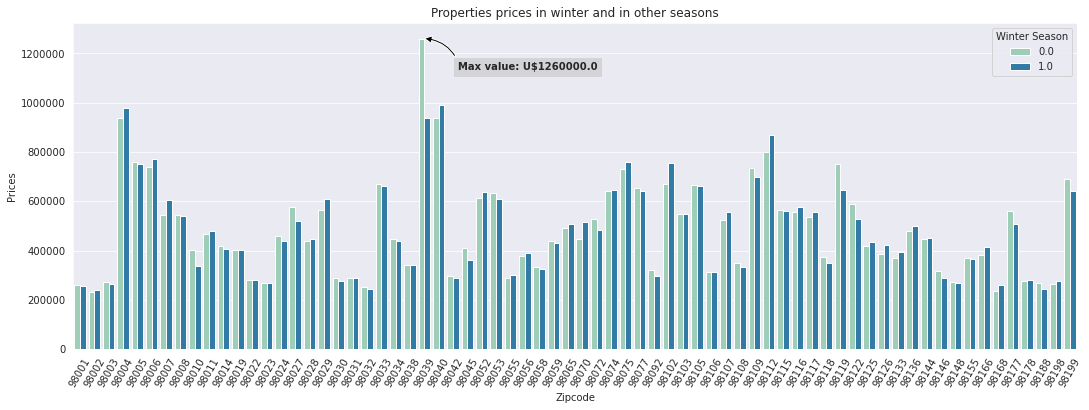

In [16]:
insight_i()

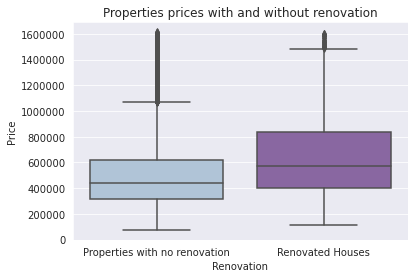

In [17]:
insight_ii()

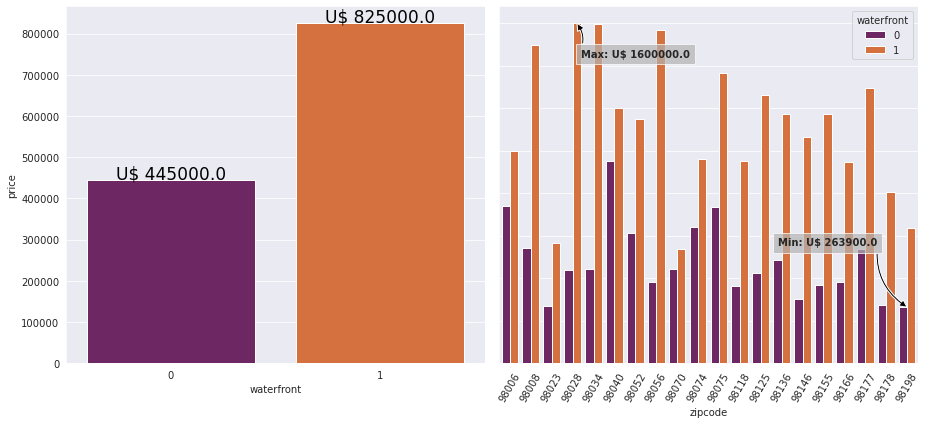

In [18]:
insight_iii()

In [19]:
df[['id','is_winter','price','median_price','winter_median_price','selling_price','profit_value']]

,id,is_winter,price,median_price,winter_median_price,selling_price,profit_value
0,7129300520,0.00,221900.00,279000.00,281000.00,266280.00,44380.00
1,4060000240,0.00,205425.00,279000.00,281000.00,246510.00,41085.00
2,4058801670,0.00,445000.00,279000.00,281000.00,NaN,NaN
3,2976800796,0.00,236000.00,279000.00,281000.00,283200.00,47200.00
4,6874200960,1.00,170000.00,279000.00,281000.00,204000.00,34000.00
...,...,...,...,...,...,...,...
21014,3835502815,0.00,1260000.00,1242500.00,937500.00,NaN,NaN
21015,3262300920,0.00,1200000.00,1242500.00,937500.00,1440000.00,240000.00
21016,3025300225,0.00,1450000.00,1242500.00,937500.00,NaN,NaN
21017,3625049079,0.00,1350000.00,1242500.00,937500.00,NaN,NaN


In [20]:
df['profit_value'].sum()

777552813.2